In [1]:
import numpy as np
from discopy import optics
from discopy.optics import Box, Id, MZI

In [2]:
# Given width and depth this code builds an array of Mach Zender interferometers

def build_chip(width, depth, params):   
    chip = Id(width)
    if width % 2 == 0:
        for i in range(depth):
            boxes = Id()
            if i % 2 == 0:
                for j in range(int(width / 2)):
                    boxes =  boxes @ MZI(*params[i, j])
            else:
                for j in range(int(width / 2) - 1):
                    boxes = boxes @ MZI(*params[i, j])
                boxes = Id(1) @ boxes @ Id(1)
            chip = chip >> boxes
    else: 
        for i in range(depth):
            boxes = Id()
            for j in range(int(width / 2)):
                    boxes =  boxes @ MZI(*params[i, j])  
            if i % 2 == 0:
                boxes = boxes @ Id(1)
            else:
                boxes = Id(1) @ boxes
            chip = chip >> boxes
    return chip

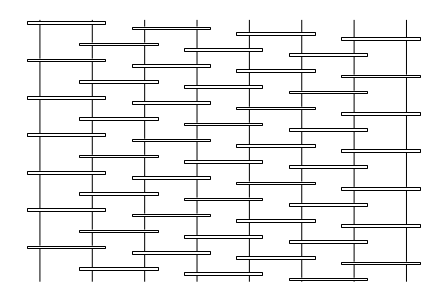

In [3]:
width = 8
depth = 14
params0 = np.random.rand(depth, int(width / 2), 2)
chip0 = build_chip(width, depth, params0)
chip0.draw(draw_type_labels=False, draw_box_labels=False)

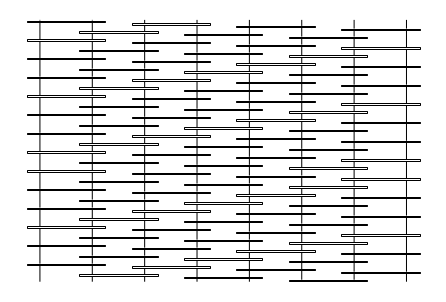

In [4]:
# Two chips can be composed in sequence with >>

params1 = np.random.rand(depth, int(width / 2), 2)
chip1 = build_chip(width, depth, params1)
(chip0 >> chip1).draw(draw_type_labels=False, draw_box_labels=False)

In [46]:
print("Choose entities and relations:")

E = ["Alice", "Bob", "Claire", "Dave"]
print(E)
R = ["loves", "hates"]
print(R)
W = E + R

print("This defines a language of subject-verb-object sentences:")

triples = [(s, v, o) for s in E for v in R for o in E]
triples

Choose entities and relations:
['Alice', 'Bob', 'Claire', 'Dave']
['loves', 'hates']
This defines a language of subject-verb-object sentences:


[('Alice', 'loves', 'Alice'),
 ('Alice', 'loves', 'Bob'),
 ('Alice', 'loves', 'Claire'),
 ('Alice', 'loves', 'Dave'),
 ('Alice', 'hates', 'Alice'),
 ('Alice', 'hates', 'Bob'),
 ('Alice', 'hates', 'Claire'),
 ('Alice', 'hates', 'Dave'),
 ('Bob', 'loves', 'Alice'),
 ('Bob', 'loves', 'Bob'),
 ('Bob', 'loves', 'Claire'),
 ('Bob', 'loves', 'Dave'),
 ('Bob', 'hates', 'Alice'),
 ('Bob', 'hates', 'Bob'),
 ('Bob', 'hates', 'Claire'),
 ('Bob', 'hates', 'Dave'),
 ('Claire', 'loves', 'Alice'),
 ('Claire', 'loves', 'Bob'),
 ('Claire', 'loves', 'Claire'),
 ('Claire', 'loves', 'Dave'),
 ('Claire', 'hates', 'Alice'),
 ('Claire', 'hates', 'Bob'),
 ('Claire', 'hates', 'Claire'),
 ('Claire', 'hates', 'Dave'),
 ('Dave', 'loves', 'Alice'),
 ('Dave', 'loves', 'Bob'),
 ('Dave', 'loves', 'Claire'),
 ('Dave', 'loves', 'Dave'),
 ('Dave', 'hates', 'Alice'),
 ('Dave', 'hates', 'Bob'),
 ('Dave', 'hates', 'Claire'),
 ('Dave', 'hates', 'Dave')]

In [54]:
# Now we construct a mapping to photonic chips

width = 4
n_photons = 2
x = [0, 1, 1, 0] # input occupation numbers
y = [0, 1, 1, 0] # output occupation numbers

print("Hardware hyperparameters:")
print(" width: {} \n number of photons: {} \n input occupations: {} \n output occupations: {}".format(width, n_photons, x, y))

Hardware hyperparameters:
 width: 4 
 number of photons: 2 
 input occupations: [0, 1, 1, 0] 
 output occupations: [0, 1, 1, 0]


In [56]:
# Given a depth for words and parameters, we have a mapping from words to photonic chips:
depth = 3 # depth for each word 

functor = lambda depth, params: {W[i] : build_chip(width, np.shape(params)[1], params[i]) for i in range(len(W))}

print("Linguistic hyperparameters:")
print(" number of entities: {} \n number of relations: {}\n depth for each word: {}".format(len(E), len(R), depth))

Linguistic hyperparameters:
 number of entities: 4 
 number of relations: 2
 depth for each word: 3


In [57]:
params = np.random.rand(len(W), depth, int(width / 2), 2)
print("Initialised random parameters of shape: {}\n".format(np.shape(params)))

print("number of words: {} \ndepth for each word: {}\nmax number of MZIs per layer : {} \nnumber of params per MZI: {}\n\n".format(*np.shape(params)))

# getting Product 
def prod(val) : 
    res = 1 
    for ele in val: 
        res *= ele 
    return res 

print("Total number of parameters: {}\n".format(prod(np.shape(params))))

F = functor(depth, params)

Initialised random parameters of shape: (6, 3, 2, 2)

number of words: 6 
depth for each word: 3
max number of MZIs per layer : 2 
number of params per MZI: 2


Total number of parameters: 72



The image of Bob is the following chip:


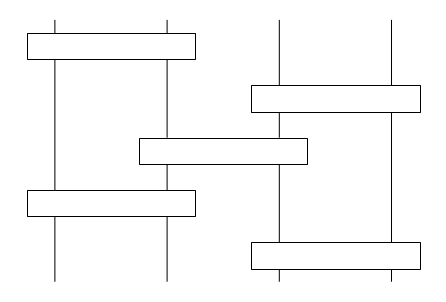

In [58]:
print("The image of Bob is the following chip:")
F["Bob"].draw(draw_type_labels=False, draw_box_labels=False)

In [59]:
# With a functor F we can evaluate a triple:

evaluate = lambda F, triple: np.absolute((F[triple[0]] >> F[triple[1]] >> F[triple[2]]).amp(n_photons, x, y))**2

print("Evaluate the triple `Alice loves Bob':")
evaluate(F, ("Alice", "loves", "Bob"))

Evaluate the triple `Alice loves Bob':


0.507100324066831

In [60]:
print("Get the scores for each triples:")
for i in range(len(triples)):
    print("{} : {}".format(evaluate(F, triples[i]), triples[i]))

Get the scores for each triples:
0.44889319685397305 : ('Alice', 'loves', 'Alice')
0.507100324066831 : ('Alice', 'loves', 'Bob')
0.42832429595340693 : ('Alice', 'loves', 'Claire')
0.49950102760705234 : ('Alice', 'loves', 'Dave')
0.4128235734575187 : ('Alice', 'hates', 'Alice')
0.510588234116155 : ('Alice', 'hates', 'Bob')
0.36244176183410487 : ('Alice', 'hates', 'Claire')
0.6752926092250792 : ('Alice', 'hates', 'Dave')
0.5646870241168632 : ('Bob', 'loves', 'Alice')
0.5997665975953831 : ('Bob', 'loves', 'Bob')
0.49781411257014835 : ('Bob', 'loves', 'Claire')
0.5852184811720511 : ('Bob', 'loves', 'Dave')
0.5141760656074458 : ('Bob', 'hates', 'Alice')
0.5535550170942259 : ('Bob', 'hates', 'Bob')
0.4035279072655946 : ('Bob', 'hates', 'Claire')
0.7115656500929479 : ('Bob', 'hates', 'Dave')
0.451273273148429 : ('Claire', 'loves', 'Alice')
0.5140127004836642 : ('Claire', 'loves', 'Bob')
0.2652362619516958 : ('Claire', 'loves', 'Claire')
0.4047362394935606 : ('Claire', 'loves', 'Dave')
0.28272